In [1]:
# importing required packages
import numpy as np
from matplotlib import pyplot as plt

# Static Linear 1D problem

Example of a simple 1D linear problem, with a chain of springs fixed at one end and a static force applied at the other.

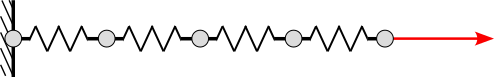

In [2]:
class Domain():
  #1D domain class
  def __init__(self, number_of_elements):
      self.number_of_elements = number_of_elements
      self.number_of_nodes = self.number_of_elements+1
      self.nodes_coordinates = np.linspace(0,1,self.number_of_nodes)
      self.connectivity = np.c_[np.linspace(0,self.number_of_nodes-2,self.number_of_nodes-1), np.linspace(1,self.number_of_nodes-1,self.number_of_nodes-1) ]

In [3]:
example_domain = Domain(number_of_elements=4)
print('Node coordinates: ', example_domain.nodes_coordinates)
print('Connectivities: \n', example_domain.connectivity)

Node coordinates:  [0.   0.25 0.5  0.75 1.  ]
Connectivities: 
 [[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]]


We will use a simple 1D Finite Element of degree 1:

In [4]:
class ReferenceElement():
    #1D finite element of degree 1
    def __init__(self):
        self.degree = 1
        self.reference_domain = np.array([-1,1])
        self.number_nodes = 2
        self.number_gauss_points = 2
        self.gauss_points_locations = np.array([-1/np.sqrt(3) , 1/np.sqrt(3)])
        self.gauss_points_weights = np.array([1,1])
        self.shape_functions_at_gauss_points =  np.array([(1-self.gauss_points_locations)/2  , (1+self.gauss_points_locations)/2])
        self.shape_functions_derivatives_at_gauss_points  =  np.array ([[-0.5, 0.5 ],[-0.5, 0.5]])
        self.shape_functions_second_derivatives_at_gauss_points = np.array ([[0, 0 ],[0, 0]])

In [5]:
class FOM_simulation():

    def __init__( self, number_of_elements=10, list_of_forces=[0,1,2]):
        self.domain = Domain(number_of_elements)
        self.reference_element = ReferenceElement()
        self.list_of_forces = list_of_forces

    def Run(self):
        self.ComputeSystemMatrix()
        self.Solve()

    def ComputeSystemMatrix(self):
        self.K = np.zeros((self.domain.number_of_nodes, self.domain.number_of_nodes))
        #element loop
        for ith_element in range(self.domain.number_of_elements):
            element_connectivity = self.domain.connectivity[ith_element, :]
            element_coordinates = self.domain.nodes_coordinates[element_connectivity.astype(int)]
            element_length =  element_coordinates[-1] - element_coordinates[0]
            K_element = np.zeros((self.reference_element.number_nodes,self.reference_element.number_nodes))
            #gauss points loop
            for i in range(self.reference_element.number_gauss_points):
                shape_function_derivative_i = self.reference_element.shape_functions_derivatives_at_gauss_points[i,:] * 2/element_length
                weight_i = self.reference_element.gauss_points_weights[i] * element_length/2
                K_element += weight_i * (shape_function_derivative_i.reshape(-1,1) @ shape_function_derivative_i.reshape(1,-1))
            #assembly
            for e_i, i in zip([0,1], element_connectivity.astype(int)):
                for e_j, j in zip([0,1],element_connectivity.astype(int)):
                    self.K[i,j] +=  K_element[e_i,e_j]

        plt.spy(self.K)
        plt.title(f'Matrix K sparsity pattern', fontsize=15, fontweight='bold')
        plt.show()

    def Solve(self):
        self.d = np.zeros((self.domain.number_of_nodes,len(self.list_of_forces)))
        K = self.K[1:,1:] #First node is fixed, so we skip it
        F = np.zeros((self.domain.number_of_nodes -1, 1))
        for i, force in enumerate(self.list_of_forces):
            F[-1] = force
            self.d[1:,i] = np.squeeze(np.linalg.solve(K,F))

In [6]:
#Launching the FOM simulation

number_of_elements = 10
list_of_forces = np.linspace(0,5,6)

fom_simulation = FOM_simulation(number_of_elements, list_of_forces) #creates the domain and the reference element

print('FOM simulation with ', fom_simulation.domain.number_of_elements, 'elements')
print('Simulating for forces: ', fom_simulation.list_of_forces)

FOM simulation with  10 elements
Simulating for forces:  [0. 1. 2. 3. 4. 5.]


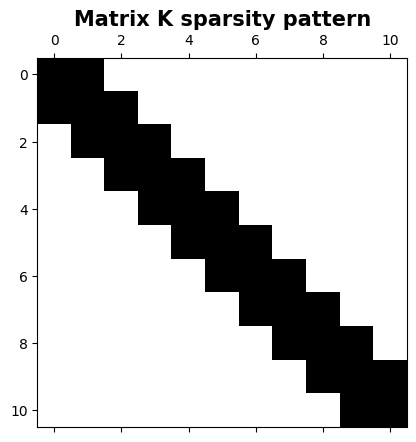

In [7]:
#Running the Simulation

fom_simulation.Run()  # creates the system matrix K and solves the system for each of the load steps

In [8]:
def plot_displacements_FOM(fom_simulation):
    snapshots = fom_simulation.d
    forces = fom_simulation.list_of_forces
    number_of_nodes = np.shape(snapshots)[0]
    for i, snapshot in enumerate(snapshots.T):
      plt.plot(np.linspace(0,number_of_nodes,number_of_nodes), snapshot, '-o',alpha=0.5,label=f'F = {forces[i]}')
    plt.title('FOM Simulation Result for all forces', fontsize=15, fontweight='bold')
    plt.legend()
    plt.ylabel('displacement')
    plt.xlabel('node')
    plt.show()

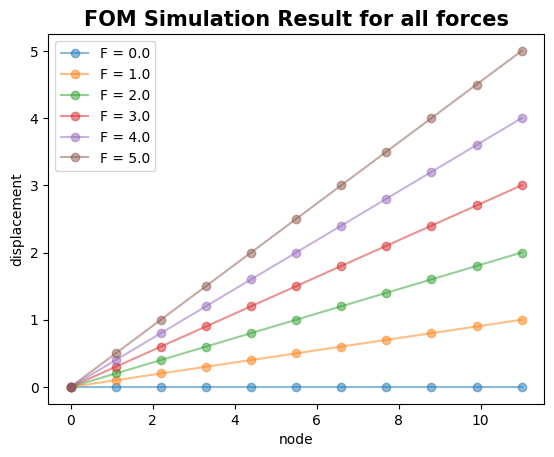

In [9]:
plot_displacements_FOM(fom_simulation)

In [10]:
#Method to print a single snapshot
def plot_snapshots_FOM(fom_simulation):
  snapshots = fom_simulation.d
  forces = fom_simulation.list_of_forces
  nodes_origin = fom_simulation.domain.nodes_coordinates
  number_of_nodes = np.shape(snapshots)[0]
  for i, snapshot in enumerate(snapshots.T):
    plt.plot(nodes_origin+snapshot, np.ones((number_of_nodes))*forces[i], '-o',alpha=0.5,label=f'F = {forces[i]}')
  plt.title('FOM Simulation Result for all forces', fontsize=15, fontweight='bold')
  plt.ylabel('applied force')
  plt.xlabel('x')

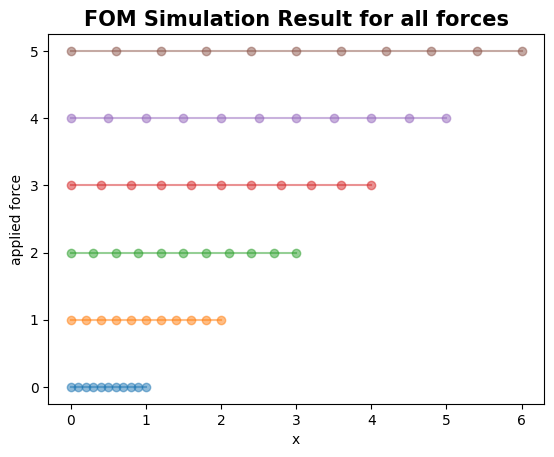

In [11]:
plot_snapshots_FOM(fom_simulation)

## Building the POD basis

Given the previous simulation, we have a collection of snapshots to use as data.

Based on it, we will build the corresponding POD basis

In [12]:
snapshot_matrix = fom_simulation.d
print('Snapshots matrix dimensions: ', snapshot_matrix.shape)

Snapshots matrix dimensions:  (11, 6)


In [13]:
# Complete the function that computes the POD basis using the SVD

def compute_basis(SnapshotsMatrix):

    ########################################
    # Task 2 (1 point)

    #YOUR CODE HERE

    u,s,v = np.linalg.svd(SnapshotsMatrix, full_matrices=False)
    plt.plot(s, '-o')
    plt.title("Singular Values of Snapshot Matrix")
    plt.show()

    u = u[:, :1]

    ########################################

    return u


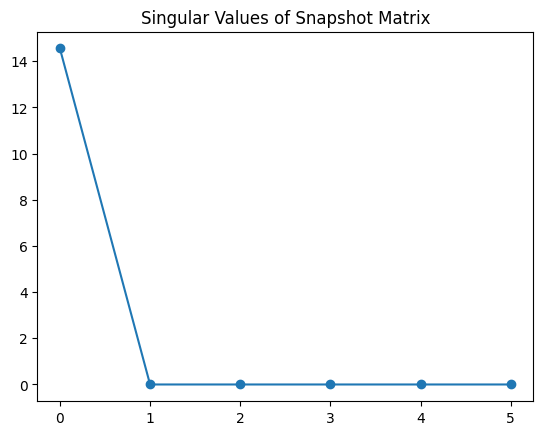

In [14]:
# call your function and obtain a basis from the FOM simulation snapshots
basis = compute_basis(snapshot_matrix)

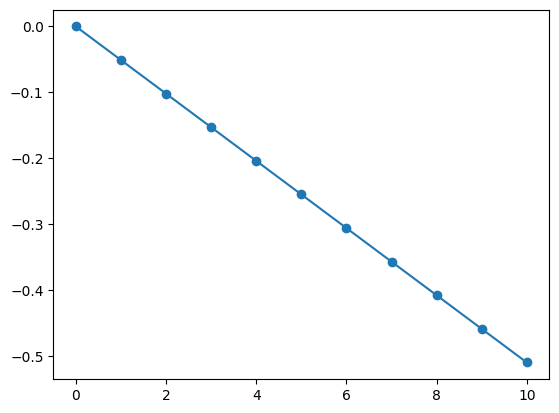

In [15]:
plt.plot(basis, '-o')
plt.show()

## ROM simulation

Once we have defined our projection matrix (a single mode in this case), we can go ahead and use it to reduce the FOM.

Let's create our ROM simulator class:

In [16]:
class Rom_Simulation(FOM_simulation):

    def __init__(self, number_of_elements, list_of_forces, basis):
        super().__init__(number_of_elements, list_of_forces) #this means that the ROM simulation constructor will do everything the parent class does (setting the domain and reference element)
        self.basis = basis

    def ComputeSystemMatrix(self):
    # We must override the parent's system matrix constructor to adapt it to the ROM formulation

    ########################################
    # Task 3 (2 points)

    #YOUR CODE HERE

        self.K = np.zeros((np.shape(self.basis)[1], np.shape(self.basis)[1]))

        #element loop
        for ith_element in range(self.domain.number_of_elements):
            element_connectivity = self.domain.connectivity[ith_element, :].astype(int)
            element_coordinates = self.domain.nodes_coordinates[element_connectivity]
            element_length = element_coordinates[-1] - element_coordinates[0]

            K_element = np.zeros((self.reference_element.number_nodes, self.reference_element.number_nodes))
            #gauss points loop
            for i in range(self.reference_element.number_gauss_points):
                 shape_function_derivative_i = self.reference_element.shape_functions_derivatives_at_gauss_points[i, :] * 2 / element_length
                 weight_i = self.reference_element.gauss_points_weights[i] * element_length / 2
                 K_element += weight_i * (shape_function_derivative_i.reshape(-1, 1) @ shape_function_derivative_i.reshape(1, -1))


            
            element_basis = self.basis[element_connectivity, :]
            self.K += element_basis.T @ K_element @ element_basis


    def Solve(self):
        self.d = np.zeros((self.domain.number_of_nodes,len(self.list_of_forces)))
        F = np.zeros((self.domain.number_of_nodes, 1))

        for i, force in enumerate(self.list_of_forces):
            F[-1] = force
            F_rom = self.basis.T @ F
            q = np.linalg.solve(self.K,F_rom) #reduced variables
            self.d[:,i] = np.squeeze(self.basis @ q)


In [17]:
#create the ROM simulation with the same parameters as the FOM(number_of_elements, number_of_steps,element_degree), plus the basis from the svd

rom_simulation = Rom_Simulation(number_of_elements, list_of_forces, basis)
rom_simulation.Run()

In [18]:
# Compare the results (one at a time)

def plot_snapshots_FOM_and_ROM(fom_simulation, rom_simulation, snapshot_to_plot):

    snapshots_FOM = fom_simulation.d
    snapshots_ROM = rom_simulation.d

    # You can ignore this. It just checks that FOM and ROM have been run with the same parameters
    incompatibility = snapshots_FOM.shape[0] != snapshots_ROM.shape[0]
    incompatibility += np.any(fom_simulation.list_of_forces != rom_simulation.list_of_forces)
    if incompatibility:
      raise Exception('Please make sure to run both FOM and ROM with the same parameters')

    number_of_nodes = snapshots_FOM.shape[0]
    x_axis = np.linspace(0, number_of_nodes, number_of_nodes)

    plt.plot(x_axis, snapshots_FOM[:, snapshot_to_plot], 'b-o', label='FOM', alpha=0.7)
    plt.plot(x_axis, snapshots_ROM[:, snapshot_to_plot], 'r-x', label='ROM', alpha=0.7)

    plt.title(f'Comparison of FOM and ROM Displacements (Snapshot {snapshot_to_plot})')
    plt.xlabel('Node')
    plt.ylabel('Displacement')
    plt.legend()
    plt.show()

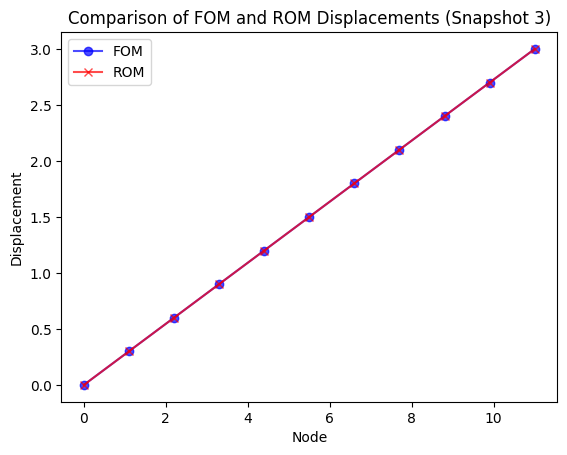

In [19]:
snapshot_to_plot = 3
plot_snapshots_FOM_and_ROM(fom_simulation, rom_simulation, snapshot_to_plot)

In [20]:
#compute the approximation error

print('approximation error: ', 100* np.linalg.norm(fom_simulation.d - rom_simulation.d)/ np.linalg.norm(fom_simulation.d ), ' %' )

approximation error:  3.45305307469911e-14  %
